In [1]:
from pathlib import Path
from numpy import array
from tensorflow.image import crop_and_resize
from tensorflow.io import decode_png, read_file

generator_glob = Path().glob('datasets/**/*.png')
ndarray_png = array(
    [
        crop_and_resize((decode_png(read_file(str(path)), 1),), ((.21, .48, .85, .71),), (0,), (300, 300))[0]
        for path in generator_glob
    ]
)
ndarray_png.shape

2025-09-16 06:28:52.217975: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758004132.231847     652 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758004132.236002     652 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758004132.248960     652 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758004132.248976     652 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758004132.248978     652 computation_placer.cc:177] computation placer alr

(899, 300, 300, 1)

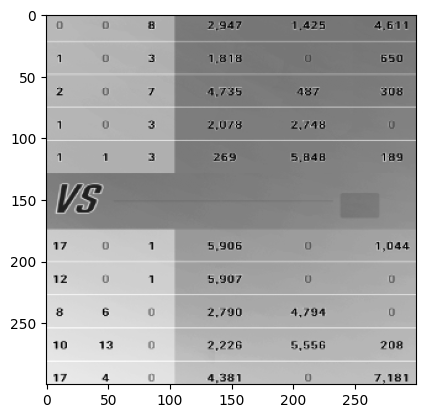

In [3]:
from matplotlib.pyplot import imshow, show

imshow(ndarray_png[0], 'Greys')
show()

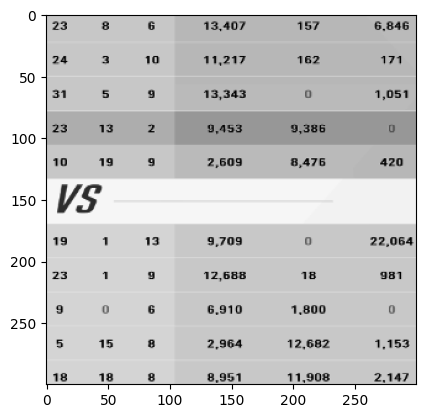

In [4]:
imshow(ndarray_png[-1], 'Greys')
show()

In [5]:
import pandas as pd
from pandas import read_csv

index_col = 0
usecols = 0, 2, 3, 4, 5, 6, 7
ndarray_reshape = pd.concat(
    (
        read_csv('datasets/role_defeat.csv', index_col=index_col, usecols=usecols),
        read_csv('datasets/role_draw.csv', index_col=index_col, usecols=usecols),
        read_csv('datasets/role_victory.csv', index_col=index_col, usecols=usecols)
    ),
    keys=['defeat', 'draw', 'victory']
).values.reshape(-1, 60)
ndarray_reshape.shape

(899, 60)

In [6]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Flatten, Dense

clear_session()
model = Sequential()
model.add(Input((300, 300, 1)))
model.add(Flatten())
model.add(Dense(300, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(60))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 90000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │    27,000,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 60)             │         6,060 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,036,460 (103.14 MB)

 Trainable params: 27,036,460 (103.14 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile('sgd', 'mse', metrics=['mae', 'mse'])

In [9]:
X_valid, X_train = ndarray_png[:10], ndarray_png[10:]
y_valid, y_train = ndarray_reshape[:10], ndarray_reshape[10:]

In [10]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30


I0000 00:00:1758004205.819816     715 service.cc:152] XLA service 0x7163bc087200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758004205.819872     715 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-09-16 06:30:05.882160: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1758004205.981918     715 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-09-16 06:30:06.783437: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_74_0', 120 bytes spill stores, 120 bytes spill loads

2025-09-16 06:30:06.970476: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_

21/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: nan - mae: nan - mse: nan

I0000 00:00:1758004210.215975     715 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-09-16 06:30:11.210211: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_74_0', 120 bytes spill stores, 120 bytes spill loads

2025-09-16 06:30:11.286090: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_74', 200 bytes spill stores, 200 bytes spill loads

2025-09-16 06:30:11.397676: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_74', 64 bytes spill stores, 64 bytes spill loads

2025-09-16 06:30:11.480129: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Reg

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: nan - mae: nan - mse: nan

2025-09-16 06:30:15.298954: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 112 bytes spill stores, 112 bytes spill loads

2025-09-16 06:30:15.970101: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 820 bytes spill stores, 864 bytes spill loads



28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 233ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: nan - mae: nan - mse: nan - val_los